In [1]:
!pip install language-tool-python
import pandas as pd
import matplotlib.pyplot as plt
from language_tool_python import LanguageTool
from tqdm import tqdm

import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import backend as K

2024-05-31 14:16:10.989059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 14:16:10.989185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 14:16:11.119826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-detection/train.csv')
dataset.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


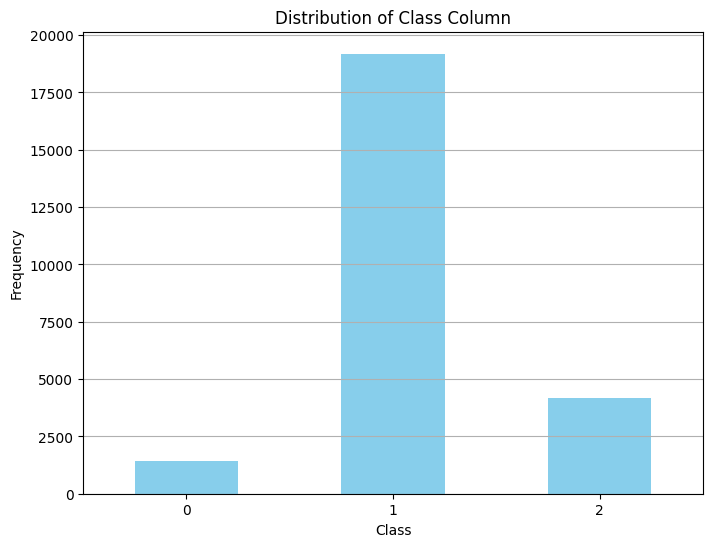

In [5]:
# Plotting the distribution of the "class" column
plt.figure(figsize=(8, 6))
dataset['class'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Class Column')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# 1. Grammar errors on raw dataset

In [248]:
# Assuming dataset2 is your DataFrame with the 'tweet' column
tool = LanguageTool('en-US')

error_counter_0 = {}
error_types_counter_0 = {}

for index in tqdm(range(dataset.shape[0])):
    matches = tool.check(dataset.loc[index, 'tweet'])
    
    error_count = len(matches)
    
    # Count the number of errors per type
    error_types = [match.ruleId for match in matches]
    for error_type in error_types:
        if error_type in error_types_counter_0:
            error_types_counter_0[error_type] += 1
        else:
            error_types_counter_0[error_type] = 1
    
    # Count the total number of errors
    if error_count in error_counter_0.keys():
        error_counter_0[error_count].append(index)
    else:
        error_counter_0[error_count] = [index]

100%|██████████| 24783/24783 [14:17<00:00, 28.90it/s]  


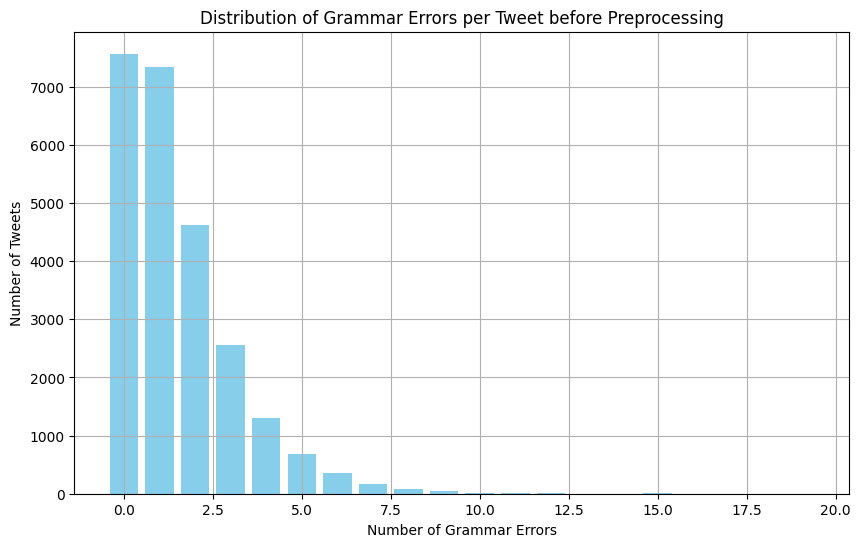

In [249]:
# Prepare data for plotting
keys = sorted(error_counter_0.keys())
values = [len(error_counter_0[k]) for k in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Number of Grammar Errors')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Grammar Errors per Tweet before Preprocessing')
plt.grid(True)
plt.show()

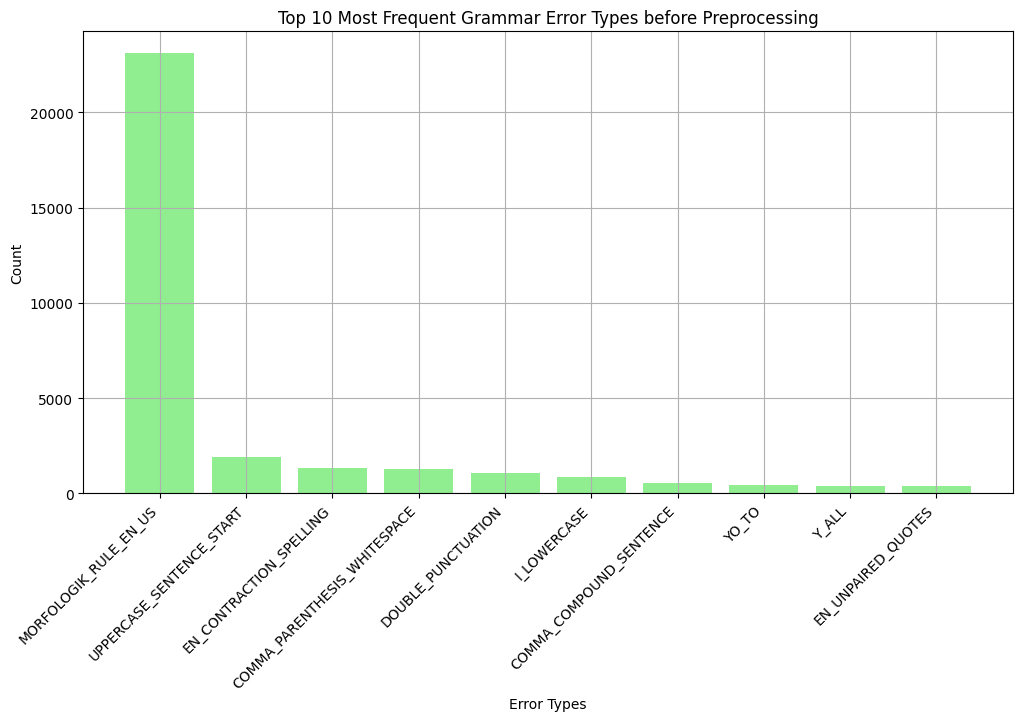

In [250]:
# Sort error types by frequency (descending)
sorted_error_types = sorted(error_types_counter_0, key=error_types_counter_0.get, reverse=True)

# Select the top n most frequent error types to plot
top_n = 10  # Adjust this value as needed

top_error_types = sorted_error_types[:top_n]
top_counts = [error_types_counter_0[error_type] for error_type in top_error_types]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_error_types, top_counts, color='lightgreen')
plt.xlabel('Error Types')
plt.ylabel('Count')
plt.title('Top {} Most Frequent Grammar Error Types before Preprocessing'.format(top_n))
plt.xticks(rotation=45, ha='right')  # Rotate labels by 30 degrees to the right
plt.grid(True)
plt.show()


# 2. Regex Preprocessing of the dataset

In [5]:
# extract the text and labels
tweet = list(dataset['tweet'])
labels = list(dataset['class'])

In [6]:
#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [7]:
# call the cleaning function
clean_tweet = preprocess(tweet)

In [254]:
tool = LanguageTool('en-US')

cleaned_error_counter_0 = {}
cleaned_error_types_counter_0 = {}

for index in tqdm(range(len(clean_tweet))):
    matches = tool.check(clean_tweet[index])
    
    error_count = len(matches)
    
    # Count the number of errors per type
    error_types = [match.ruleId for match in matches]
    for error_type in error_types:
        if error_type in cleaned_error_types_counter_0:
            cleaned_error_types_counter_0[error_type] += 1
        else:
            cleaned_error_types_counter_0[error_type] = 1
    
    # Count the total number of errors
    if error_count in cleaned_error_counter_0.keys():
        cleaned_error_counter_0[error_count].append(index)
    else:
        cleaned_error_counter_0[error_count] = [index]

100%|██████████| 24783/24783 [13:38<00:00, 30.27it/s]  


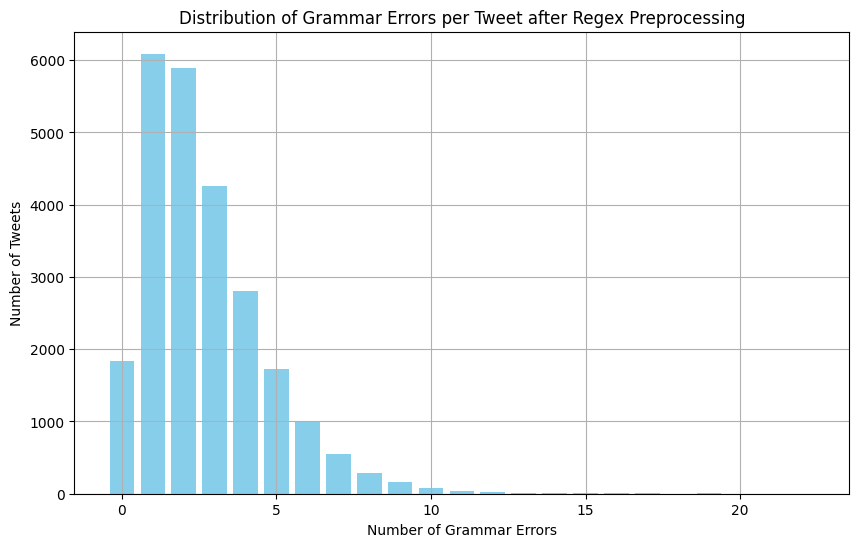

In [255]:
# Prepare data for plotting
keys = sorted(cleaned_error_counter_0.keys())
values = [len(cleaned_error_counter_0[k]) for k in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Number of Grammar Errors')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Grammar Errors per Tweet after Regex Preprocessing')
plt.grid(True)
plt.show()

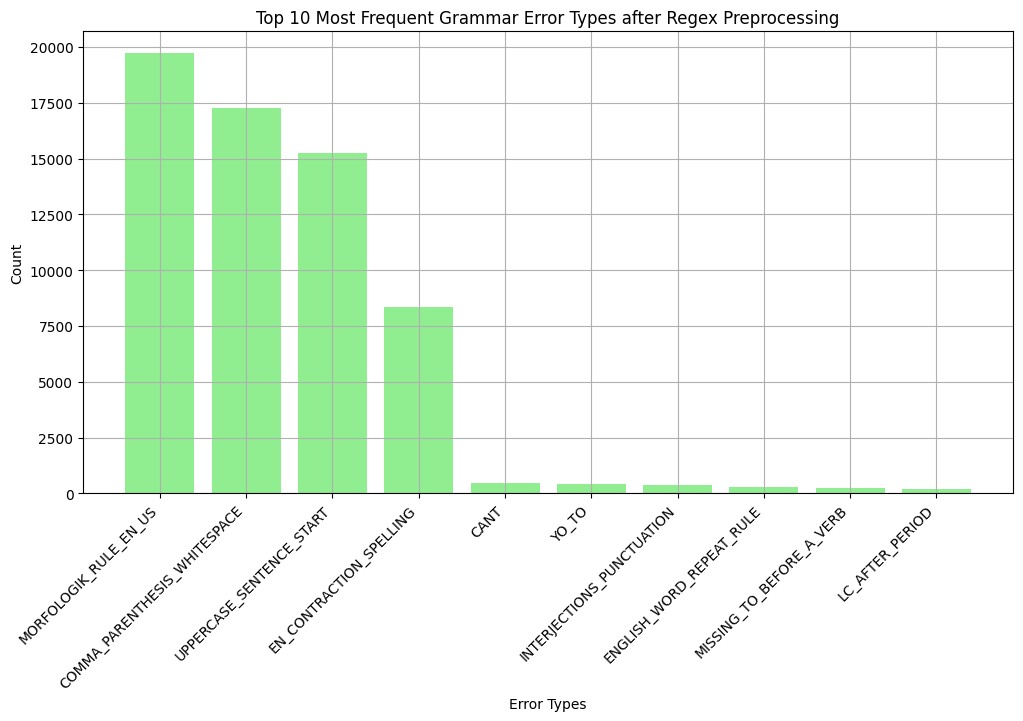

In [256]:
# Sort error types by frequency (descending)
sorted_error_types = sorted(cleaned_error_types_counter_0, key=cleaned_error_types_counter_0.get, reverse=True)

# Select the top n most frequent error types to plot
top_n = 10  # Adjust this value as needed

top_error_types = sorted_error_types[:top_n]
top_counts = [cleaned_error_types_counter_0[error_type] for error_type in top_error_types]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_error_types, top_counts, color='lightgreen')
plt.xlabel('Error Types')
plt.ylabel('Count')
plt.title('Top {} Most Frequent Grammar Error Types after Regex Preprocessing'.format(top_n))
plt.xticks(rotation=45, ha='right')  # Rotate labels by 30 degrees to the right
plt.grid(True)
plt.show()


# 3. Grammar errors after applying GEC on raw dataset

In [12]:
model_id = 'gotutiyan/gector-roberta-base-5k'
model = GECToR.from_pretrained(model_id)
if torch.cuda.is_available():
    model.cuda()
tokenizer = AutoTokenizer.from_pretrained(model_id)
encode, decode = load_verb_dict('/kaggle/working/verb-form-vocab.txt')

corrected_raw_tweet = predict(
    model, tokenizer, tweet,
    encode, decode,
    keep_confidence=0.0,
    min_error_prob=0.0,
    n_iteration=2,
    batch_size=64,
)

Iteratoin 0. the number of to_be_processed: 24783


100%|██████████| 388/388 [01:20<00:00,  4.82it/s]


Iteratoin 1. the number of to_be_processed: 15007


100%|██████████| 235/235 [00:50<00:00,  4.65it/s]


In [258]:
for i in range(1010, 1020):

    print("Original: " + dataset.loc[i, 'tweet'])
    print("GEC applied: " + corrected_raw_tweet[i])
    print('\n')

Original: &#128514;&#128557;&#128128; RT @iDO_me2: Hood hoes love Harrell football team&#128528;
GEC applied: &#128514;&#128557;&#128128; RT @iDO_me2: Hood hoes love Harrell football team&#128528;


Original: &#128514;&#9995;&#8220;@iSell_Pussy4EBT &#8220;@Sco_ForIt bucket RT &#8220;@iSell_Pussy4EBT: Trash &#8220;@_manlookaKeedY: All you bitches is my SONS &#128520; http://t.co/LrMBWFPMaE
GEC applied: &#128514;&#9995;&#8220;@iSell_Pussy4EBT &#8220;@Sco_ForIt bucket RT &#8220;@iSell_Pussy4EBT: Trash &#8220;@_manlookaKeedY: All you bitches is my SONS &#128520; http://t.co/LrMBWFPMaE


Original: &#128514;RT @1BaD_dOc: I hate when people get on my bad side cause I honestly don't like to act like a bitch
GEC applied: &#128514;RT @1BaD_dOc: I hate when people get on my bad side , 'cause I honestly don't like to act like a bitch .


Original: &#128518;"@QbF150: On a leash &#128555;RT @80sbaby4life: Just pussy &#128553;"
GEC applied: &#128518;"@QbF150: On a leash &#128555;RT @80sbaby4life: Jus

In [259]:
tool = LanguageTool('en-US')

corrected_raw_counter_0 = {}
corrected_raw_types_counter_0 = {}

for index in tqdm(range(len(corrected_raw_tweet))):
    matches = tool.check(corrected_raw_tweet[index])
    
    error_count = len(matches)
    
    # Count the number of errors per type
    error_types = [match.ruleId for match in matches]
    for error_type in error_types:
        if error_type in corrected_raw_types_counter_0:
            corrected_raw_types_counter_0[error_type] += 1
        else:
            corrected_raw_types_counter_0[error_type] = 1
    
    # Count the total number of errors
    if error_count in corrected_raw_counter_0.keys():
        corrected_raw_counter_0[error_count].append(index)
    else:
        corrected_raw_counter_0[error_count] = [index]

100%|██████████| 24783/24783 [14:01<00:00, 29.46it/s]  


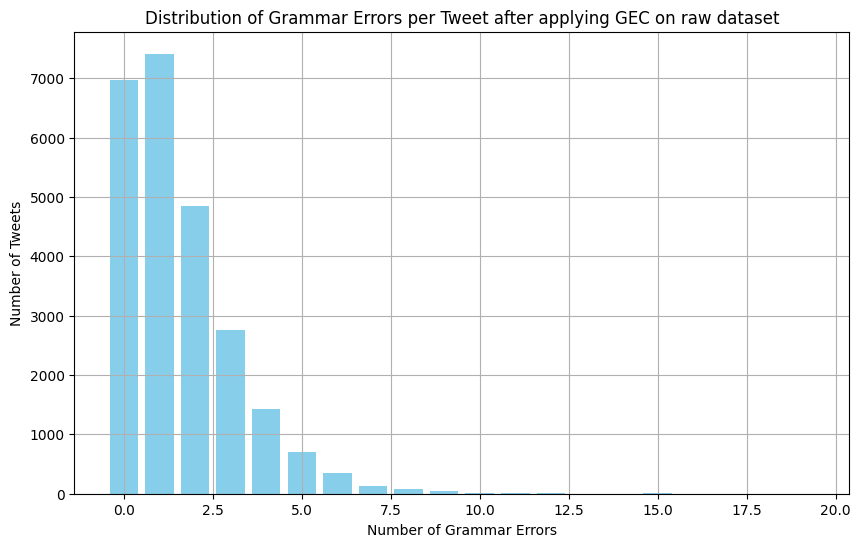

In [260]:
# Prepare data for plotting
keys = sorted(corrected_raw_counter_0.keys())
values = [len(corrected_raw_counter_0[k]) for k in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Number of Grammar Errors')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Grammar Errors per Tweet after applying GEC on raw dataset')
plt.grid(True)
plt.show()

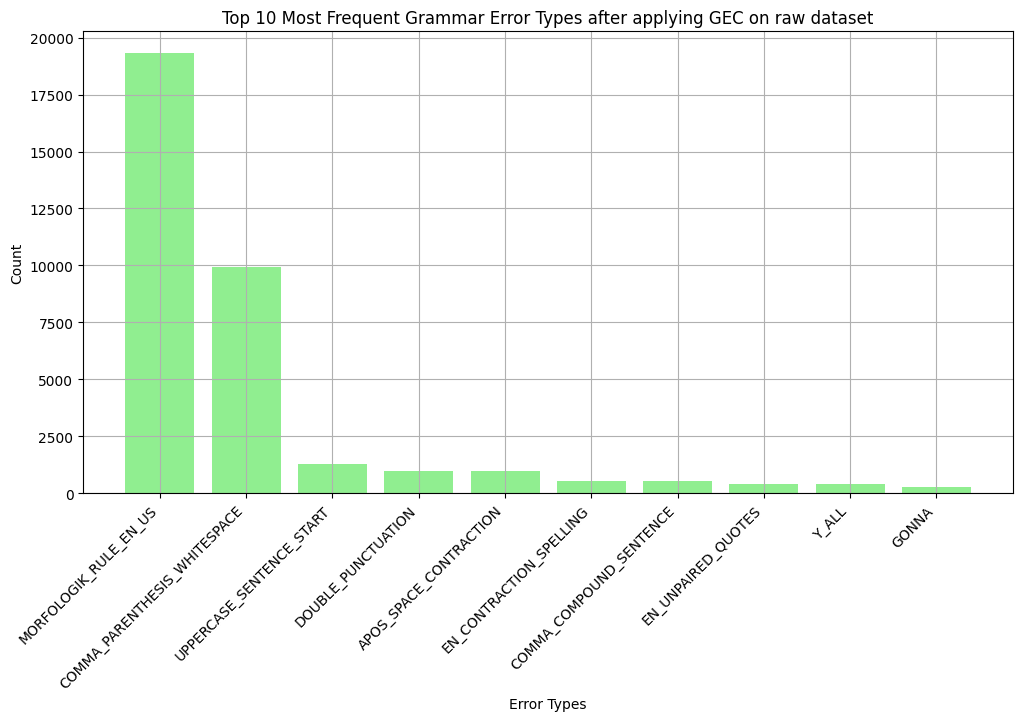

In [261]:
# Sort error types by frequency (descending)
sorted_error_types = sorted(corrected_raw_types_counter_0, key=corrected_raw_types_counter_0.get, reverse=True)

# Select the top n most frequent error types to plot
top_n = 10  # Adjust this value as needed

top_error_types = sorted_error_types[:top_n]
top_counts = [corrected_raw_types_counter_0[error_type] for error_type in top_error_types]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_error_types, top_counts, color='lightgreen')
plt.xlabel('Error Types')
plt.ylabel('Count')
plt.title('Top {} Most Frequent Grammar Error Types after applying GEC on raw dataset'.format(top_n))
plt.xticks(rotation=45, ha='right')  # Rotate labels by 30 degrees to the right
plt.grid(True)
plt.show()


# Apply GEC on preprocessed dataset

In [9]:
import sys
sys.path.append('/kaggle/input/mygector/pytorch/good/1/')

! pip install -r /kaggle/input/mygector/pytorch/good/1/requirements.txt

from gector.modeling import GECToR
from gector.predict import predict, load_verb_dict
from transformers import AutoTokenizer
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 75.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 

In [13]:
model_id = 'gotutiyan/gector-roberta-base-5k'
model = GECToR.from_pretrained(model_id)
if torch.cuda.is_available():
    model.cuda()
tokenizer = AutoTokenizer.from_pretrained(model_id)
encode, decode = load_verb_dict('/kaggle/working/verb-form-vocab.txt')

corrected_tweet = predict(
    model, tokenizer, clean_tweet,
    encode, decode,
    keep_confidence=0.0,
    min_error_prob=0.0,
    n_iteration=2,
    batch_size=64,
)

Iteratoin 0. the number of to_be_processed: 24783


100%|██████████| 388/388 [01:16<00:00,  5.09it/s]


Iteratoin 1. the number of to_be_processed: 17909


100%|██████████| 280/280 [00:55<00:00,  5.00it/s]


In [264]:
for i in range(1010, 1020):

    print("Original: " + dataset.loc[i, 'tweet'])
    print("Regex parsing: " + clean_tweet[i])
    print("GEC applied: " + corrected_tweet[i])
    print('\n')

Original: &#128514;&#128557;&#128128; RT @iDO_me2: Hood hoes love Harrell football team&#128528;
Regex parsing: Hood hoes love Harrell football team
GEC applied: Hood hoes love Harrell football team


Original: &#128514;&#9995;&#8220;@iSell_Pussy4EBT &#8220;@Sco_ForIt bucket RT &#8220;@iSell_Pussy4EBT: Trash &#8220;@_manlookaKeedY: All you bitches is my SONS &#128520; http://t.co/LrMBWFPMaE
Regex parsing: bucket Trash bitches SONS
GEC applied: bucket Trash bitches SONS


Original: &#128514;RT @1BaD_dOc: I hate when people get on my bad side cause I honestly don't like to act like a bitch
Regex parsing: hate people get bad side cause honestly dont like act like bitch
GEC applied: I hate people who get bad side 'cause I , honestly , do like acting like bitches .


Original: &#128518;"@QbF150: On a leash &#128555;RT @80sbaby4life: Just pussy &#128553;"
Regex parsing: leash pussy
GEC applied: leash pussy


Original: &#128520;&#127383; we snap chatted for one night lol. But you're cute. Sna

In [265]:
tool = LanguageTool('en-US')

corrected_cleaned_counter_0 = {}
corrected_cleaned_types_counter_0 = {}

for index in tqdm(range(len(corrected_tweet))):
    matches = tool.check(corrected_tweet[index])
    
    error_count = len(matches)
    
    # Count the number of errors per type
    error_types = [match.ruleId for match in matches]
    for error_type in error_types:
        if error_type in corrected_cleaned_types_counter_0:
            corrected_cleaned_types_counter_0[error_type] += 1
        else:
            corrected_cleaned_types_counter_0[error_type] = 1
    
    # Count the total number of errors
    if error_count in corrected_cleaned_counter_0.keys():
        corrected_cleaned_counter_0[error_count].append(index)
    else:
        corrected_cleaned_counter_0[error_count] = [index]

100%|██████████| 24783/24783 [13:39<00:00, 30.25it/s]  


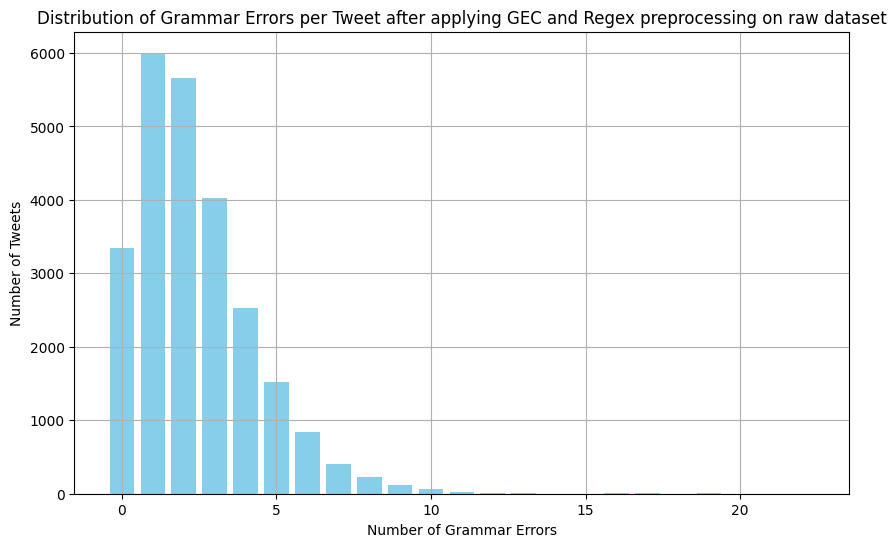

In [266]:
# Prepare data for plotting
keys = sorted(corrected_cleaned_counter_0.keys())
values = [len(corrected_cleaned_counter_0[k]) for k in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Number of Grammar Errors')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Grammar Errors per Tweet after applying GEC and Regex preprocessing on raw dataset')
plt.grid(True)
plt.show()

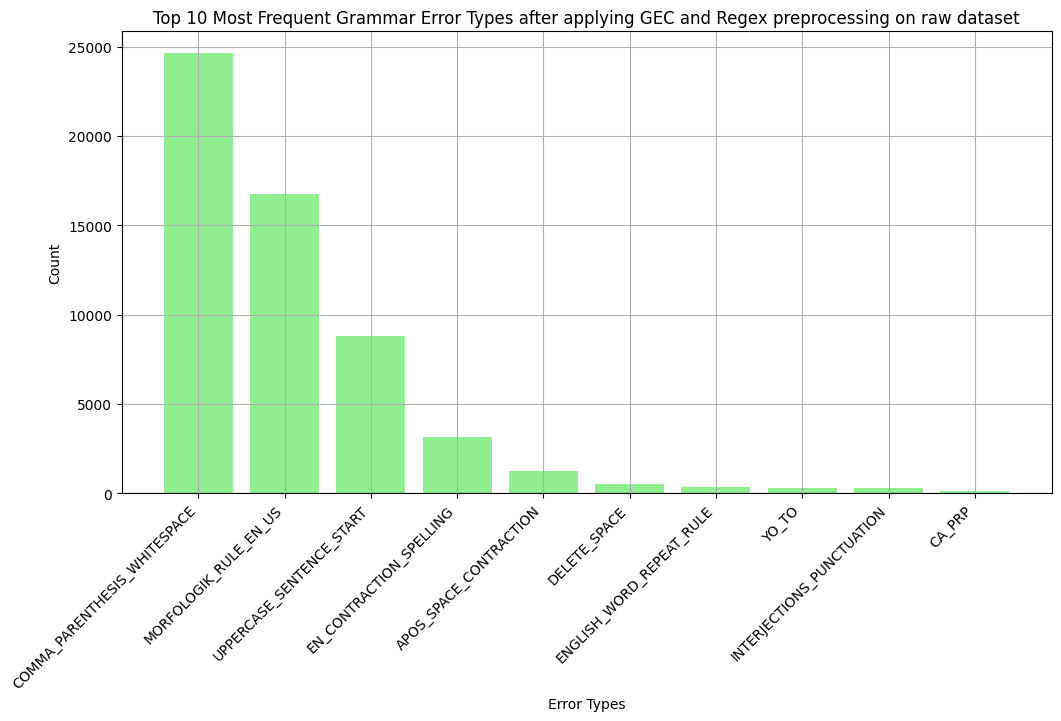

In [267]:
# Sort error types by frequency (descending)
sorted_error_types = sorted(corrected_cleaned_types_counter_0, key=corrected_cleaned_types_counter_0.get, reverse=True)

# Select the top n most frequent error types to plot
top_n = 10  # Adjust this value as needed

top_error_types = sorted_error_types[:top_n]
top_counts = [corrected_cleaned_types_counter_0[error_type] for error_type in top_error_types]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_error_types, top_counts, color='lightgreen')
plt.xlabel('Error Types')
plt.ylabel('Count')
plt.title('Top {} Most Frequent Grammar Error Types after applying GEC and Regex preprocessing on raw dataset'.format(top_n))
plt.xticks(rotation=45, ha='right')  # Rotate labels by 30 degrees to the right
plt.grid(True)
plt.show()


37945
66078
39358
59362


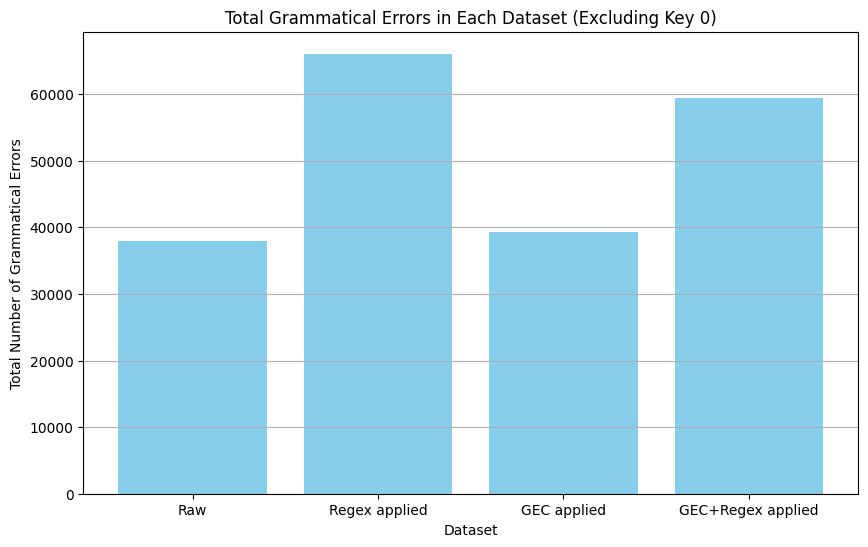

In [268]:
import matplotlib.pyplot as plt

# Function to calculate total errors in a dataset
def calculate_total_errors(error_dict):
    total_errors = sum(len(index_list)* key for key, index_list in error_dict.items() if key != '0')
    print(total_errors)
    return total_errors

# Calculate total errors for each dataset
total_errors_raw = calculate_total_errors(error_counter_0)
total_errors_cleaned = calculate_total_errors(cleaned_error_counter_0)
total_errors_corrected_raw = calculate_total_errors(corrected_raw_counter_0)
total_errors_corrected_cleaned = calculate_total_errors(corrected_cleaned_counter_0)

# Create lists for plotting
datasets = ['Raw', 'Regex applied', 'GEC applied', 'GEC+Regex applied']
total_errors = [total_errors_raw, total_errors_cleaned, total_errors_corrected_raw, total_errors_corrected_cleaned]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(datasets, total_errors, color='skyblue')
plt.xlabel('Dataset')
plt.ylabel('Total Number of Grammatical Errors')
plt.title('Total Grammatical Errors in Each Dataset (Excluding Key 0)')
plt.grid(axis='y')
plt.show()


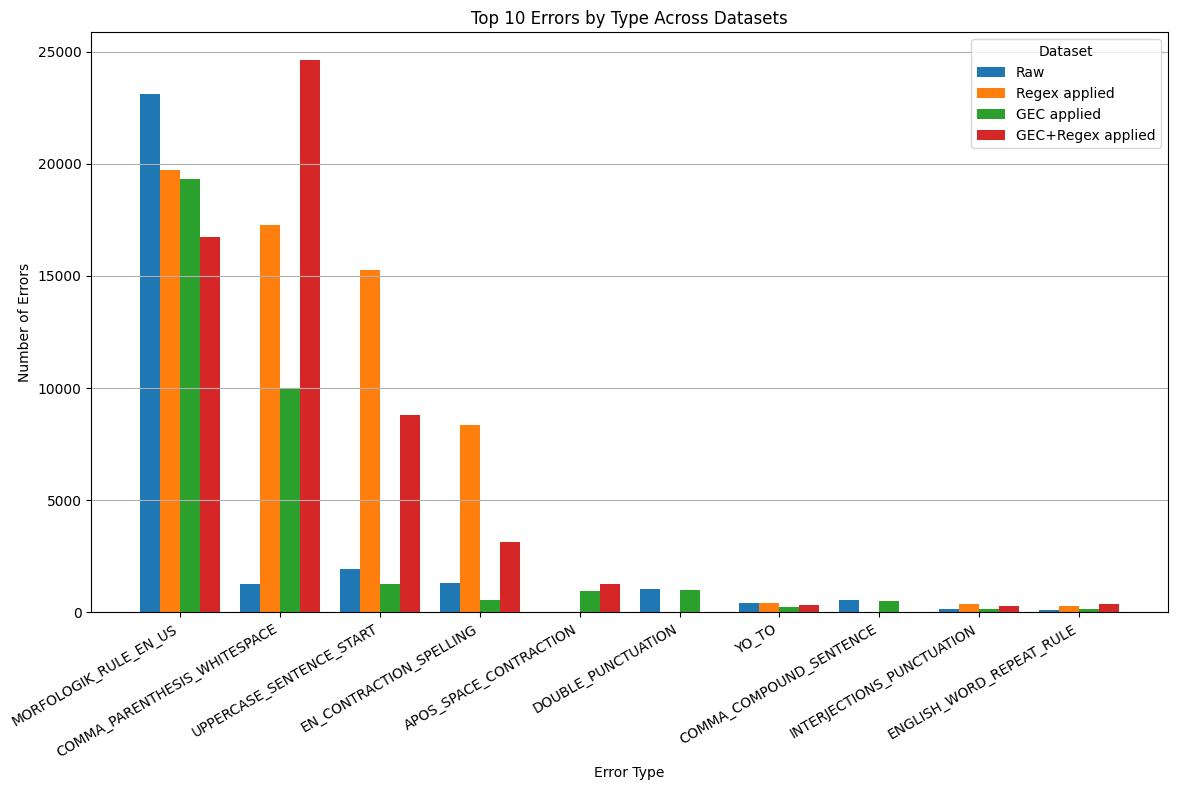

In [269]:
import matplotlib.pyplot as plt
import numpy as np

# Combine all error type dictionaries
all_error_types = {
    'Raw': error_types_counter_0,
    'Regex applied': cleaned_error_types_counter_0,
    'GEC applied': corrected_raw_types_counter_0,
    'GEC+Regex applied': corrected_cleaned_types_counter_0
}

# Get the top 10 most frequent error types across all datasets
error_type_counts = {}
for error_type_dict in all_error_types.values():
    for error_type, count in error_type_dict.items():
        error_type_counts[error_type] = error_type_counts.get(error_type, 0) + count

top_10_error_types = sorted(error_type_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Prepare data for plotting
num_datasets = len(all_error_types)
num_error_types = len(top_10_error_types)
dataset_names = list(all_error_types.keys())
error_type_labels = [error_type for error_type, _ in top_10_error_types]
dataset_values = np.zeros((num_error_types, num_datasets))

for j, (dataset, error_type_dict) in enumerate(all_error_types.items()):
    for i, (error_type, _) in enumerate(top_10_error_types):
        dataset_values[i, j] = error_type_dict.get(error_type, 0)

# Plotting
plt.figure(figsize=(12, 8))

bar_width = 0.2
for i in range(num_datasets):
    plt.bar(np.arange(num_error_types) + i * bar_width, dataset_values[:, i], width=bar_width, label=dataset_names[i])

# Customize plot
plt.xlabel('Error Type')
plt.ylabel('Number of Errors')
plt.title('Top 10 Errors by Type Across Datasets')
plt.xticks(np.arange(num_error_types) + bar_width * (num_datasets - 1) / 2, error_type_labels, rotation=30, ha='right')
plt.legend(title="Dataset")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [270]:
error_types_counter_0

{'MORFOLOGIK_RULE_EN_US': 23094,
 'COMMA_COMPOUND_SENTENCE': 543,
 'HE_VERB_AGR': 289,
 'DOUBLE_PUNCTUATION': 1055,
 'EN_UNPAIRED_QUOTES': 400,
 'CAUSE_BECAUSE': 140,
 'EN_CONTRACTION_SPELLING': 1316,
 'COMMA_PARENTHESIS_WHITESPACE': 1275,
 'UPPERCASE_SENTENCE_START': 1914,
 'I_LOWERCASE': 841,
 'EVERYDAY_EVERY_DAY': 30,
 'CANT': 88,
 'WONT_CONTRACTION': 25,
 'IT_IS': 107,
 'MISSING_TO_BEFORE_A_VERB': 16,
 'COMMA_COMPOUND_SENTENCE_2': 97,
 'PRP_THE': 212,
 'EN_A_VS_AN': 160,
 'EN_COMPOUNDS_PUSSY_CATS': 8,
 'PHRASE_REPETITION': 51,
 'CA_BRAND_NEW': 2,
 'SENTENCE_WHITESPACE': 264,
 'WANNA': 299,
 'UH_UH_COMMA': 15,
 'YO_TO': 426,
 'Y_ALL': 404,
 'FR': 17,
 'PRP_PAST_PART': 158,
 'EN_COMPOUNDS_BALD_HEADED': 3,
 'YEAR_OLD_HYPHEN': 20,
 'ENGLISH_WORD_REPEAT_RULE': 126,
 'PERS_PRONOUN_AGREEMENT': 108,
 'TWITTER': 45,
 'PRP_MD_NN': 9,
 'IS_VBZ': 3,
 'OUTTA': 78,
 'EM_ME': 140,
 'PRP_VBG': 188,
 'LETS_LET': 16,
 'WERE_WHERE': 4,
 'NON3PRS_VERB': 119,
 'POSSESSIVE_APOSTROPHE': 39,
 'INTERJECTIO

# Sentiment analysis on raw

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweet, labels, test_size=0.2, random_state=42)

In [15]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [16]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

an outlier detected: [4, 75, 90, 117, 17, 830, 1, 3538, 13, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 1808, 52]
an outlier detected: [45, 972, 282, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 4065, 175, 1, 139, 282, 100, 316, 29, 36, 2, 33]


In [17]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [18]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [19]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [20]:
# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# checking the model parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=1,
    validation_data=(X_test, y_test)
)

310/310 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.7833 - f1: 0.6755 - loss: 0.6544 - precision: 0.7278 - recall: 0.6538 - val_accuracy: 0.8888 - val_f1: 0.8884 - val_loss: 0.3334 - val_precision: 0.9046 - val_recall: 0.8731


# Sentiment analysis on dataset with regex applied (cleaned)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

# checking the model parameters
model.summary()

# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=1,
    validation_data=(X_test, y_test)
)

num test tweet: 4957
num train tweet: 19826


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7755 - f1: 0.6842 - loss: 0.6387 - precision: 0.7258 - recall: 0.6600 - val_accuracy: 0.8826 - val_f1: 0.8833 - val_loss: 0.3408 - val_precision: 0.8981 - val_recall: 0.8693


# Sentiment analysis on dataset with GEC applied on raw (corrected)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(corrected_raw_tweet, labels, test_size=0.2, random_state=42)

## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

# checking the model parameters
model.summary()

# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=1,
    validation_data=(X_test, y_test)
)

an outlier detected: [4, 73, 86, 118, 11, 822, 1, 3498, 14, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 1794, 54]
an outlier detected: [51, 898, 271, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 4011, 177, 1, 139, 271, 810, 388, 28, 29, 2, 35]
num test tweet: 4

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - accuracy: 0.7758 - f1: 0.6804 - loss: 0.6435 - precision: 0.7277 - recall: 0.6587 - val_accuracy: 0.8790 - val_f1: 0.8798 - val_loss: 0.3472 - val_precision: 0.8932 - val_recall: 0.8670


# Sentiment analysis on dataset with GEC and Regex applied on raw

In [27]:
X_train, X_test, y_train, y_test = train_test_split(corrected_tweet, labels, test_size=0.2, random_state=42)

## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

# checking the model parameters
model.summary()

# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=1,
    validation_data=(X_test, y_test)
)

num test tweet: 4957
num train tweet: 19826


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7822 - f1: 0.7078 - loss: 0.6291 - precision: 0.7588 - recall: 0.6835 - val_accuracy: 0.8852 - val_f1: 0.8810 - val_loss: 0.3477 - val_precision: 0.8998 - val_recall: 0.8632
